**Date**: 2019-02-08

**Authors**: Adam Stafford

**Purpose**: To test whether the experiment using the bidirectional LTSM from 2018-01-29 will work without the DNA sequence using only the TFBS data.

**Background**:
- The idea of this experiment is to understand how the TFBS data contributes to the accuracy of the model from 2018-01-29. For this purpose, we run the neural network without the DNA sequences.

**Experiment**:

In [1]:
import pickle
import numpy as np
import matplotlib.pyplot as plt

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #2
  (fname, cnt))
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #3
  (fname, cnt))


Load the `pickle` buffered list:

In [2]:
with open("../data/new_list_buffer.txt", "rb") as buff:
    seq_record_list = pickle.load(buff)

The following cell retains only 4800 sequences, for the purpose of testing speed. It also randomly shuffles the 4800 sequences.

In [3]:
seq_record_list = seq_record_list[:4800]
from random import shuffle
shuffle(seq_record_list)

The following cell transforms the data into a format that is recognizable by the neural network model, but ignores the DNA sequence data.

In [4]:
# A helper function to flatten a 2d list to 1d.
# Input: [[1, 2], [2, 3], [3, 4, 5]]
# Output: [1, 2, 2, 3, 3, 4, 5]
def flatten(lst):
    new_lst = []
    for sub_lst in lst:
        for item in sub_lst:
            new_lst.append(item)
    return new_lst

# A helper function to transform a lst so that its length becomes read_len by:
# 1. If len(lst) > read_len, curtail the end of the lst.
# 2. If len(lst) < read_len, keep extending the end of the lst with 0 (NA).
def curtail(lst, read_len):
    for i in range(0, len(lst)):
        lst[i] = lst[i][4:8]
    if len(lst) > read_len:
        lst = lst[:read_len]
    else:
        for i in range(read_len - len(lst)):
            lst.append([0, 0, 0, 0])
    return lst

# Produce the train-test split
# length_read: the length that you want all DNA sequences to conform to
def prepare_input(training_size, test_size, length_read):
    X_train = []
    y_train = []
    X_test = []
    y_test = []
    seq_count = 0
    while seq_count < training_size:
        X_train.append(flatten(curtail(seq_record_list[seq_count][3], length_read)))
        y_train.append(int(seq_record_list[seq_count][1]))
        seq_count += 1
    while seq_count < (training_size + test_size):
        X_test.append(flatten(curtail(seq_record_list[seq_count][3], length_read)))
        y_test.append(int(seq_record_list[seq_count][1]))
        seq_count += 1
    return X_train, y_train, X_test, y_test

# Turn list into numpy tensors that can directly feed into a neural network model
def to_np_array(X_train, y_train, X_test, y_test):
    X_train = np.array(X_train)
    y_train = np.array(y_train)
    if len(y_train.shape) == 1:
        y_train = np.transpose(np.array([y_train]))
    X_test = np.array(X_test)
    y_test = np.transpose(np.array(y_test))
    if len(y_test.shape) == 1:
        y_test = np.transpose(np.array([y_test]))
    return X_train, y_train, X_test, y_test

In [5]:
X_train, y_train, X_test, y_test = prepare_input(4320, 480, 1000)
X_train, y_train, X_test, y_test = to_np_array(X_train, y_train, X_test, y_test)
[X_train.shape, y_train.shape, X_test.shape, y_test.shape]

[(4320, 4000), (4320, 1), (480, 4000), (480, 1)]

The following cells build a recurrent network with one bidirectional LSTM layer.

In [6]:
from keras.models import Model, Sequential
from keras.layers import Dense, CuDNNLSTM, Bidirectional

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [7]:
X_train_rnn = X_train.reshape(4320, 1000, 4)

In [8]:
model = Sequential()
#model.add(CuDNNLSTM(8, input_shape=(1000, 8), return_sequences=True))
model.add(Bidirectional(CuDNNLSTM(8), input_shape=(1000, 4)))
#model.add(CuDNNLSTM(8, return_sequences=True))
#model.add(CuDNNLSTM(4, return_sequences=True))
#model.add(CuDNNLSTM(4))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(X_train_rnn, y_train, epochs=150, batch_size=128, validation_split=0.1)

Train on 3888 samples, validate on 432 samples
Epoch 1/150
3888/3888 [==============================] - 72s 19ms/step - loss: 0.7024 - acc: 0.4807 - val_loss: 0.6898 - val_acc: 0.5139
Epoch 2/150
3888/3888 [==============================] - 5s 1ms/step - loss: 0.6876 - acc: 0.5180 - val_loss: 0.6766 - val_acc: 0.5926
Epoch 3/150
3888/3888 [==============================] - 5s 1ms/step - loss: 0.6765 - acc: 0.5586 - val_loss: 0.6664 - val_acc: 0.6319
Epoch 4/150
3888/3888 [==============================] - 5s 1ms/step - loss: 0.6673 - acc: 0.5864 - val_loss: 0.6585 - val_acc: 0.6435
Epoch 5/150
3888/3888 [==============================] - 5s 1ms/step - loss: 0.6600 - acc: 0.6060 - val_loss: 0.6547 - val_acc: 0.6458
Epoch 6/150
3888/3888 [==============================] - 5s 1ms/step - loss: 0.6536 - acc: 0.6229 - val_loss: 0.6499 - val_acc: 0.6435
Epoch 7/150
3888/3888 [==============================] - 5s 1ms/step - loss: 0.6476 - acc: 0.6301 - val_loss: 0.6447 - val_acc: 0.6412
Epoch 

Epoch 61/150
3888/3888 [==============================] - 5s 1ms/step - loss: 0.4931 - acc: 0.7641 - val_loss: 0.5386 - val_acc: 0.7361
Epoch 62/150
3888/3888 [==============================] - 5s 1ms/step - loss: 0.4930 - acc: 0.7644 - val_loss: 0.5274 - val_acc: 0.7477
Epoch 63/150
3888/3888 [==============================] - 5s 1ms/step - loss: 0.4886 - acc: 0.7667 - val_loss: 0.5287 - val_acc: 0.7407
Epoch 64/150
3888/3888 [==============================] - 5s 1ms/step - loss: 0.4839 - acc: 0.7698 - val_loss: 0.5143 - val_acc: 0.7431
Epoch 65/150
3888/3888 [==============================] - 5s 1ms/step - loss: 0.4834 - acc: 0.7685 - val_loss: 0.5072 - val_acc: 0.7523
Epoch 66/150
3888/3888 [==============================] - 5s 1ms/step - loss: 0.4793 - acc: 0.7721 - val_loss: 0.5074 - val_acc: 0.7523
Epoch 67/150
3888/3888 [==============================] - 5s 1ms/step - loss: 0.4797 - acc: 0.7693 - val_loss: 0.5115 - val_acc: 0.7500
Epoch 68/150
3888/3888 [========================

3888/3888 [==============================] - 5s 1ms/step - loss: 0.4030 - acc: 0.8272 - val_loss: 0.4586 - val_acc: 0.7870
Epoch 122/150
3888/3888 [==============================] - 5s 1ms/step - loss: 0.4008 - acc: 0.8282 - val_loss: 0.4577 - val_acc: 0.7847
Epoch 123/150
3888/3888 [==============================] - 5s 1ms/step - loss: 0.4022 - acc: 0.8297 - val_loss: 0.4543 - val_acc: 0.7963
Epoch 124/150
3888/3888 [==============================] - 5s 1ms/step - loss: 0.3982 - acc: 0.8305 - val_loss: 0.4495 - val_acc: 0.7917
Epoch 125/150
3888/3888 [==============================] - 5s 1ms/step - loss: 0.4038 - acc: 0.8259 - val_loss: 0.4386 - val_acc: 0.8125
Epoch 126/150
3888/3888 [==============================] - 5s 1ms/step - loss: 0.3982 - acc: 0.8269 - val_loss: 0.4477 - val_acc: 0.8009
Epoch 127/150
3888/3888 [==============================] - 5s 1ms/step - loss: 0.3942 - acc: 0.8308 - val_loss: 0.4519 - val_acc: 0.7986
Epoch 128/150
3888/3888 [==============================

**Result**:

The following cell **visualizes** the training/validation accuracies and losses over each epoch.

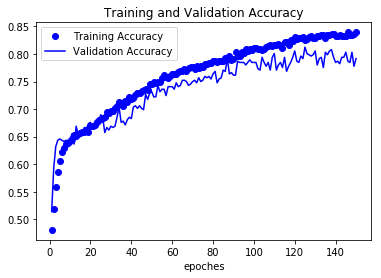

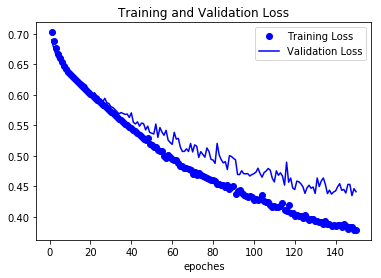

In [9]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training Accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('epoches')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('epoches')
plt.legend()

plt.show()

In [10]:
import utility
utility.save_model(model, 'models/adam_2019_02_08_2.json', 'models/adam_2019_02_08_weights_2.h5')


Save model to models/adam_2019_02_08_2.json


**Conclusion**:

- Using only TFBS data but not DNA sequences, the neural network is able to produce results similar to using both DNA and TFBS sequences. It is possible that the TFBS data is enough to make good predictions.